In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import gym
import math
plt.rcParams['figure.figsize'] = (15, 7)

In [87]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    argmax_action = np.argmax(q_values)
    probs = epsilon * np.ones(action_n) / action_n
    probs[argmax_action] += 1 - epsilon
    action = np.random.choice(np.arange(action_n), p = probs)
    return action

def discrete_state(state):
    bins = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    state = [max(-0.99, min(0.99, s)) for s in state]
    t = [bins[i] for i in np.digitize(state, bins)]
    return tuple(t)

def step_decay(epoch, total_epochs):
   initial_epsilon = 1
   drop = 0.95
   epochs_drop = int(total_epochs / 100)
   epsilon = initial_epsilon * math.pow(drop,  
           math.floor((1 + epoch)/epochs_drop))
   return epsilon

def exp_decay(epoch, episode_n):
   epsilon_initial = 1
   k = 1 / (episode_n * 0.35)
   epsilon = epsilon_initial * np.exp(-k*epoch)
   return epsilon

def time_decay(episode_n, epsilon):
    lr = 1 / (episode_n * 0.35)
    decay = lr / episode_n
    epsilon *= (1. / (1. + decay * episode_n))
    return epsilon

In [88]:
def MonteCarlo(env, episode_n, epsilon_decay = "normal", t_max = 500, gamma = 0.99):
    state_n = env.observation_space.n
    action_n = env.action_space.n
    
    Q = np.zeros((state_n, action_n))
    N = np.zeros((state_n, action_n))
    epsilon = 1
    
    epsilon_arr = []
    
    total_rewards = []
    for episode in range(episode_n):
        states, actions, rewards = [], [], []
        
        state = env.reset()
        for t in range(t_max):
            states.append(state)
            
            action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
            actions.append(action)
            
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            
            
            if done:
                break
            
        total_rewards.append(sum(rewards))
        
        G = np.zeros(len(rewards))
        G[-1] = rewards[-1]
        
        for t in range(len(rewards) - 2, -1, -1):
            G[t] = rewards[t] + gamma * G[t + 1]
        
        for t in range(len(rewards)):
            Q[states[t]][actions[t]] += (G[t] - Q[states[t]][actions[t]]) / (N[states[t]][actions[t]] + 1)
            N[states[t]][actions[t]] += 1
        
        if epsilon_decay == "normal":
            epsilon -= 1 / episode_n
            
        if epsilon_decay == "time_based":
            epsilon = time_decay(episode_n, epsilon)
            
        if epsilon_decay == "step_decay":
            epsilon = step_decay(episode, episode_n)
            
        if epsilon_decay == "exp_decay":
            epsilon = step_decay(episode, episode_n)
            epsilon_arr.append(epsilon)
        
    return total_rewards

# def MonteCarlo(env, episode_n, epsilon_decay = "normal", t_max = 500, gamma = 0.99):
#     action_n = env.action_space.n
    
#     Q = {}
#     N = {}
#     epsilon = 1
#     lr = 1 / (episode_n * 0.35)
#     decay = lr / episode_n
    
#     epsilon_arr = []
    
#     total_rewards = []
#     for episode in range(episode_n):
#         states, actions, rewards = [], [], []
        
#         state = discrete_state(env.reset())
        
#         for t in range(t_max):
#             states.append(state)

#             if state not in Q :
#                 Q[state] = np.zeros(action_n)
            
#             action = get_epsilon_greedy_action(Q[state], epsilon, action_n)
#             actions.append(action)
            
#             state, reward, done, _ = env.step(action)
#             state = discrete_state(state)
#             rewards.append(reward)
            
#             if done:
#                 break
            
#         total_rewards.append(sum(rewards))
        
#         G = np.zeros(len(rewards))
#         G[-1] = rewards[-1]
        
#         for t in range(len(rewards) - 2, -1, -1):
#             G[t] = rewards[t] + gamma * G[t + 1]
        
#         for t in range(len(rewards)):
            
#             if states[t] not in N:
#                 N[states[t]] = np.zeros(action_n)
                
#             Q[states[t]][actions[t]] += (G[t] - Q[states[t]][actions[t]]) / (N[states[t]][actions[t]] + 1)
#             N[states[t]][actions[t]] += 1
        
#         if epsilon_decay == "normal":
#             epsilon -= 1 / episode_n
            
#         if epsilon_decay == "time_based":
#             epsilon *= (1. / (1. + decay * episode_n))
            
#         if epsilon_decay == "step_decay":
#             epsilon = step_decay(episode, episode_n)
            
#         if epsilon_decay == "exp_decay":
#             epsilon = step_decay(episode, episode_n)
#             epsilon_arr.append(epsilon)
            
#     return total_rewards, epsilon_arr

<Axes: >

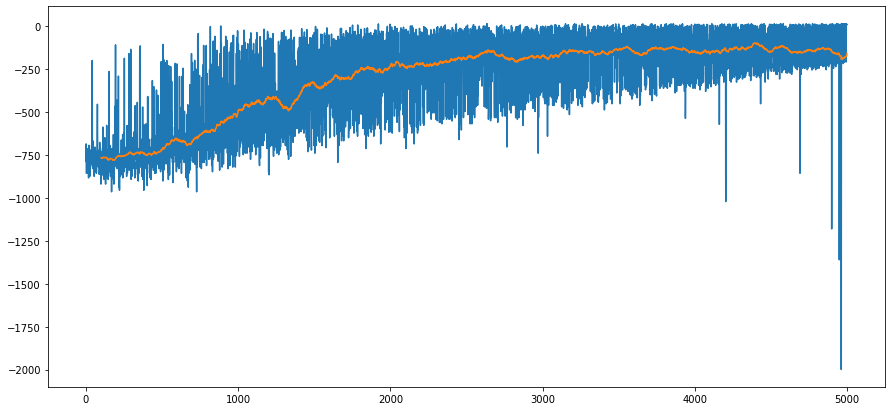

In [78]:
env = gym.make('Taxi-v3')

total_rewards_regular = MonteCarlo(env, episode_n = 5000)

plt.plot(total_rewards_regular)
pd.Series(total_rewards_regular).rolling(100).mean().plot()

<Axes: >

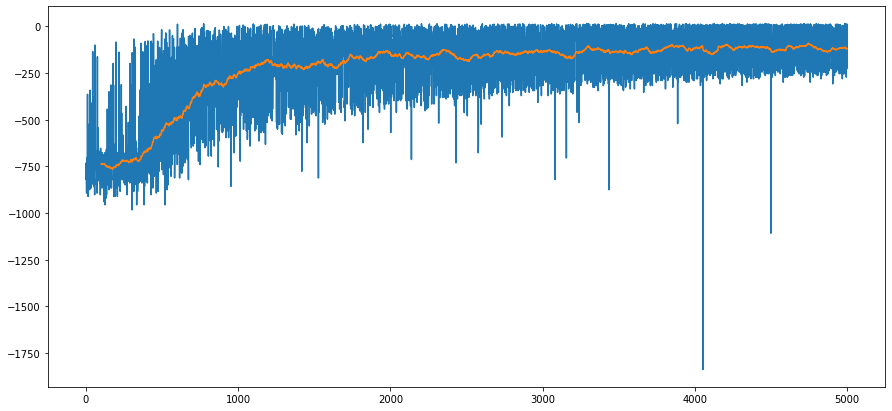

In [89]:
env = gym.make('Taxi-v3')

total_rewards_time_based = MonteCarlo(env, episode_n = 5000, epsilon_decay = "time_based")

plt.plot(total_rewards_time_based)
pd.Series(total_rewards_time_based).rolling(100).mean().plot()

<Axes: >

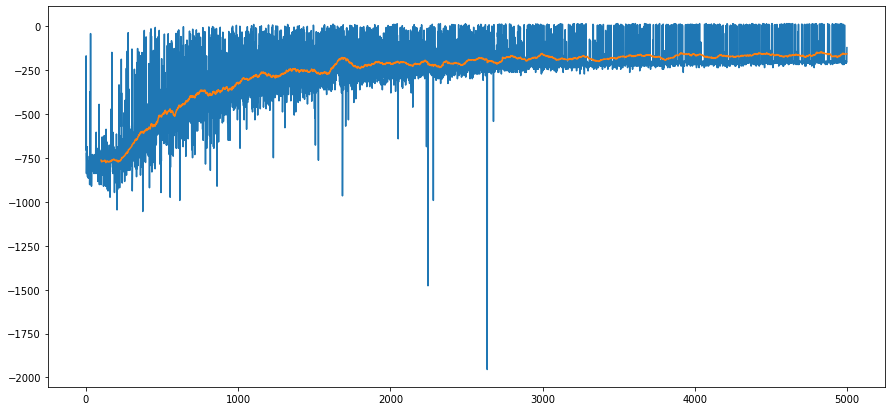

In [81]:
env = gym.make('Taxi-v3')

total_rewards_step_decay = MonteCarlo(env, episode_n = 5000, epsilon_decay = "step_decay")

plt.plot(total_rewards_step_decay)
pd.Series(total_rewards_step_decay).rolling(100).mean().plot()

<Axes: >

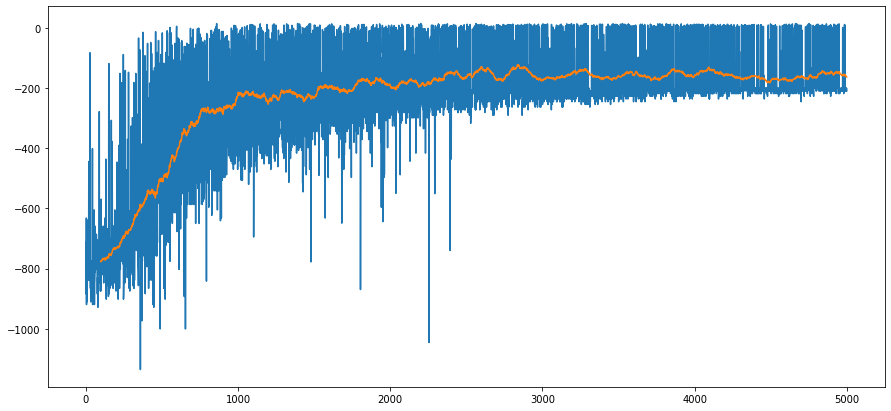

In [82]:
env = gym.make('Taxi-v3')
total_rewards_exp_decay = MonteCarlo(env, episode_n = 5000, epsilon_decay = "exp_decay")

plt.plot(total_rewards_exp_decay)
pd.Series(total_rewards_exp_decay).rolling(100).mean().plot()

Text(0.5, 1.0, 'Smoothed with rolling window of 100')

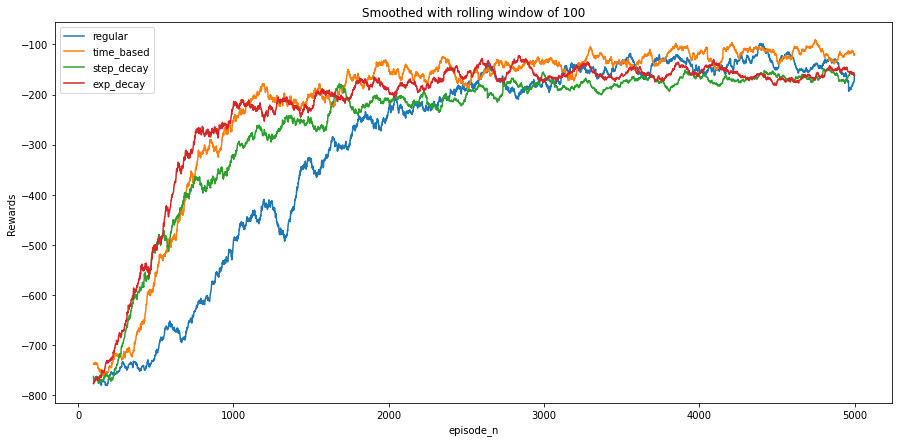

In [90]:
plt.plot(pd.Series(total_rewards_regular).rolling(100).mean(), label = 'regular')
plt.plot(pd.Series(total_rewards_time_based).rolling(100).mean(), label = 'time_based')
plt.plot(pd.Series(total_rewards_step_decay).rolling(100).mean(), label = 'step_decay')
plt.plot(pd.Series(total_rewards_exp_decay).rolling(100).mean(), label = 'exp_decay')
plt.ylabel("Rewards")
plt.xlabel("episode_n")
plt.legend(loc = 'best')
plt.title("Smoothed with rolling window of 100")